<a href="https://colab.research.google.com/github/Sudipta-Mitra/Stock-Price-Trend-Prediction-with-LSTM/blob/main/stock_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df=pd.read_csv("/content/reliance_ohlcv.csv")

In [3]:
df.tail()

,Price,Close,High,Low,Open,Volume
3697,2024-12-24,1217.8858642578125,1228.6429501715868,1216.1428258096823,1217.4377030050357,6734917
3698,2024-12-26,1211.7105712890625,1222.8161189414398,1209.4196721335327,1219.3798917928577,10016178
3699,2024-12-27,1216.1927490234375,1223.0154756156849,1212.1588111658666,1213.4536884394554,7000397
3700,2024-12-30,1205.8837890625,1218.3340640862093,1203.294156174512,1211.5611874241417,8818766
3701,2024-12-31,1210.6148681640625,1214.2503727116298,1201.3519366916562,1203.1945530395503,6405475


In [4]:
df

,Price,Close,High,Low,Open,Volume
0,Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,218.5930938720703,221.76376542820617,207.68885732873463,221.76376542820617,76646086
3,2010-01-05,217.61749267578125,233.71474007258507,216.54028253029978,233.71474007258507,21392825
4,2010-01-06,221.13369750976562,222.45481176562942,217.60733879271046,219.4873823501729,23691760
...,...,...,...,...,...,...
3697,2024-12-24,1217.8858642578125,1228.6429501715868,1216.1428258096823,1217.4377030050357,6734917
3698,2024-12-26,1211.7105712890625,1222.8161189414398,1209.4196721335327,1219.3798917928577,10016178
3699,2024-12-27,1216.1927490234375,1223.0154756156849,1212.1588111658666,1213.4536884394554,7000397
3700,2024-12-30,1205.8837890625,1218.3340640862093,1203.294156174512,1211.5611874241417,8818766


In [5]:
# Reset the index to drop the first 2 rows by integer index
df = df.reset_index(drop=True)

In [6]:
# Drop the first 2 rows (Ticker + NaN headers)
df = df.drop([0, 1])

In [ ]:
# Convert columns
df['Date'] = pd.to_datetime(df['Price']) # Assuming 'Price' column contains the Date
df = df.set_index('Date')
df = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

In [9]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,218.593094,221.763765,207.688857,221.763765,76646086.0
2010-01-05,217.617493,233.714740,216.540283,233.714740,21392825.0
2010-01-06,221.133698,222.454812,217.607339,219.487382,23691760.0
2010-01-07,224.802292,226.621363,219.101189,221.133678,26197920.0
2010-01-08,224.212906,226.377502,222.759684,225.198657,15110149.0
...,...,...,...,...,...
2024-12-24,1217.885864,1228.642950,1216.142826,1217.437703,6734917.0
2024-12-26,1211.710571,1222.816119,1209.419672,1219.379892,10016178.0
2024-12-27,1216.192749,1223.015476,1212.158811,1213.453688,7000397.0


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
train =df.loc['2010-01-01':'2020-12-31']
test = df.loc['2021-01-01':'2024-12-31']

In [14]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [15]:
#Create Sequences
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step, 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(scaled_train, time_step)
X_test, y_test = create_sequences(scaled_test, time_step)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0145
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0014
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0013
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 8.2450e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 7.8046e-04
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 9.5616e-04
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 7.6647e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 7.1963e-04
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 7.2711e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 7.8063e-04
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 5.8129e-04
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 6.6522e-04
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 7.8587e-04
Epoch 15/50
83/83 ━━━━━━━

In [19]:
#  Predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [21]:
# Inverse transform to get actual prices
# Create temporary arrays with the same number of features as the original data
train_pred_full = np.zeros((train_pred.shape[0], scaled_train.shape[1]))
test_pred_full = np.zeros((test_pred.shape[0], scaled_test.shape[1]))
y_train_actual_full = np.zeros((y_train.shape[0], scaled_train.shape[1]))
y_test_actual_full = np.zeros((y_test.shape[0], scaled_test.shape[1]))


# Place the predictions and actual values in the first column (assuming 'Close' was the first column used for scaling)
train_pred_full[:, 0] = train_pred[:, 0]
test_pred_full[:, 0] = test_pred[:, 0]
y_train_actual_full[:, 0] = y_train[:]
y_test_actual_full[:, 0] = y_test[:]

# Inverse transform the full arrays
train_pred = scaler.inverse_transform(train_pred_full)[:, 0]
test_pred = scaler.inverse_transform(test_pred_full)[:, 0]
y_train_actual = scaler.inverse_transform(y_train_actual_full)[:, 0]
y_test_actual = scaler.inverse_transform(y_test_actual_full)[:, 0]

In [22]:
# 8. Evaluation Metrics
mae = mean_absolute_error(y_test_actual, test_pred)
rmse = math.sqrt(mean_squared_error(y_test_actual, test_pred))
mape = np.mean(np.abs((y_test_actual - test_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, test_pred)

In [23]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

MAE: 18.48
RMSE: 23.64
MAPE: 1.53%
R²: 0.9784


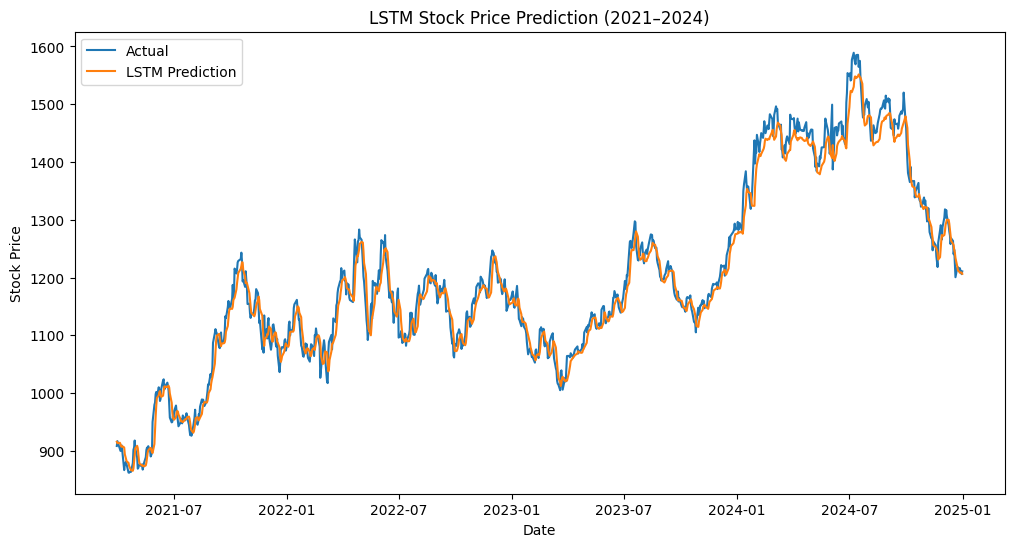

In [24]:
# 9. Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index[time_step:], y_test_actual, label="Actual")
plt.plot(test.index[time_step:], test_pred, label="LSTM Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Stock Price Prediction (2021–2024)")
plt.legend()
plt.show()

In [37]:
import pickle, joblib
from sklearn.preprocessing import MinMaxScaler

# Recreate and refit the scaler using the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train) # Assuming 'train' DataFrame is available from previous cells

# Save the refitted scaler safely with joblib
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']